In [0]:
import cv2
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
PATH = '/content/drive/My Drive/Bengali/data/'
PATH_RESIZE = '/content/drive/My Drive/Bengali/data/resize/'

In [0]:
def Resize(df,size=64):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

#128, 64, 42

In [0]:
for size in [128]:#[128, 82, 68, 42]:
  print(f'Resize: {size}')
  for num, dt in enumerate(['train_image_data_0.parquet', 'train_image_data_1.parquet',
                              'train_image_data_2.parquet', 'train_image_data_3.parquet']):
    data = pd.read_parquet(PATH + f'{dt}')        
    r = Resize(data, size)
    r.to_feather(PATH + f'train_data_{num}_{size}.feather')
    del data
    del r
    gc.collect()

Resize: 128


100%|██████████| 50210/50210 [01:18<00:00, 635.64it/s]


In [0]:
def resize(df, size=64):
  """code from kaggle""""
  resized = {}
  resize_size=64
  angle=0    
  for i in tqdm(range(df.shape[0])):
    #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
    image=df.loc[df.index[i]].values.reshape(137,236)
    #Centering
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    matrix = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    #Scaling
    matrix = cv2.getRotationMatrix2D(image_center, 0, 1.0)
    image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    #Removing Blur
    #aug = A.GaussianBlur(p=1.0)
    #image = aug(image=image)['image']
    #Noise Removing
    #augNoise=A.MultiplicativeNoise(p=1.0)
    #image = augNoise(image=image)['image']
    #Removing Distortion
    #augDist=A.ElasticTransform(sigma=50, alpha=1, alpha_affine=10, p=1.0)
    #image = augDist(image=image)['image']
    #Brightness
    augBright=A.RandomBrightnessContrast(p=1.0)
    image = augBright(image=image)['image']
    _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

    idx = 0 
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)
    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)

    roi = image[ymin:ymax,xmin:xmax]
    resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
    #image=affine_image(image)
    #image= crop_resize(image)
    #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
    #image=resize_image(image,(64,64))
    #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
    #gaussian_3 = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT) #unblur
    #image = cv2.addWeighted(image, 1.5, gaussian_3, -0.5, 0, image)
    #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
    #image = cv2.filter2D(image, -1, kernel)
    #ret,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    resized[df.index[i]] = resized_roi.reshape(-1)   
  resized = pd.DataFrame(resized).T
  return resized

In [0]:
size = 64
for num, dt in enumerate(['train_image_data_0.parquet', 'train_image_data_1.parquet',
                          'train_image_data_2.parquet', 'train_image_data_3.parquet']):
  data = pd.read_parquet(PATH + f'{dt}').drop(['image_id'], axis=1)       
  r = resize(data, size=size)
  r.columns = [str(i) for i in r.columns]
  r.to_feather(PATH_RESIZE + f'train_data_{num}_{size}_new.feather')
  del data
  del r
  gc.collect()

100%|██████████| 50210/50210 [02:13<00:00, 375.78it/s]


In [0]:
r = pd.read_feather(PATH_RESIZE + 'train_data_0_64_new.feather')
r

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,246,246,247,247,247,246,247,245,247,247,246,245,248,247,247,247,248,248,249,247,246,246,246,245,242,221,159,104,73,76,98,139,190,226,242,245,246,246,246,248,...,226,246,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,248
1,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,253,252,252,249,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,252,215,165,208,185,187,255,255,255,255,255,255,255,255,255,255,255
2,245,246,246,245,243,243,243,244,245,244,244,244,245,245,245,244,244,244,244,245,246,246,245,244,243,243,245,240,237,241,239,240,237,227,217,206,182,154,138,130,...,191,197,207,216,223,224,236,240,241,242,243,242,243,245,242,239,243,245,234,223,223,220,225,238,242,243,244,244,244,243,243,243,231,188,129,95,94,111,150,208
3,245,248,246,247,246,246,246,243,241,245,232,173,120,105,117,193,239,245,245,245,246,244,241,234,224,205,172,139,104,78,62,64,81,118,169,213,239,243,244,245,...,248,248,249,247,247,248,248,248,248,247,249,249,248,247,246,245,245,244,232,216,202,200,206,219,234,243,245,247,249,249,248,247,249,250,248,250,250,249,250,250
4,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,229,226,225,...,216,149,41,48,168,224,226,227,229,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,215,215,215,215,215,215,215,215,214,214,215,215,215,214,213,212,213,212,213,213,213,213,213,214,213,212,213,212,213,214,213,211,213,214,209,207,201,203,195,204,...,213,213,214,213,215,215,213,214,214,214,214,214,213,184,120,162,211,212,214,214,215,213,213,214,215,215,215,215,215,215,214,212,213,214,214,214,215,215,215,215
50206,233,233,233,233,234,232,231,231,232,231,229,228,231,227,229,230,228,227,225,224,223,215,208,216,225,227,226,226,224,224,227,227,228,234,234,234,234,234,234,234,...,137,71,137,202,226,229,227,228,229,232,232,232,232,233,232,232,232,232,232,232,233,233,233,233,233,233,233,234,234,234,234,234,234,234,234,234,234,234,234,234
50207,238,235,233,239,242,237,237,238,233,235,238,237,236,238,238,237,233,238,238,235,232,208,94,112,216,233,234,236,238,241,234,233,236,235,236,231,232,237,237,238,...,120,104,208,243,242,242,242,243,243,243,245,245,244,243,241,243,244,244,243,242,242,243,244,245,245,244,245,246,244,243,244,243,243,244,245,244,240,237,242,243
50208,234,230,232,228,223,227,224,217,209,205,198,187,171,169,174,171,171,162,152,148,146,148,147,149,152,152,154,157,161,165,172,185,194,199,205,215,222,223,225,228,...,237,237,237,237,240,238,237,237,236,234,233,231,232,232,230,231,229,229,230,230,227,227,224,224,230,234,233,233,235,234,232,234,229,215,195,164,159,151,151,176


In [0]:
data = pd.read_parquet(PATH + 'train_image_data_0.parquet').drop(['image_id'], axis=1)
r = resize(data, size=size, need_progress_bar=True)

100%|██████████| 50210/50210 [01:42<00:00, 492.04it/s]


In [0]:
r.columns = [str(i) for i in r.columns]
r.to_feather(PATH_RESIZE + f'train_data_{num}_{size}_new.feather')

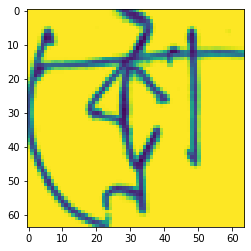

In [0]:
plt.imshow(r.iloc[0].values.reshape(64, 64))

#in risizezz

test same line in code before

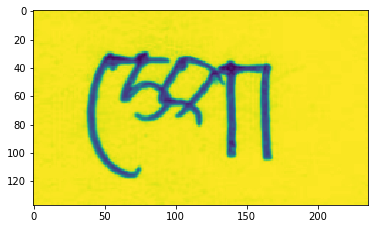

In [0]:
img = data.iloc[5].values.reshape(137, 236)
plt.imshow(img)

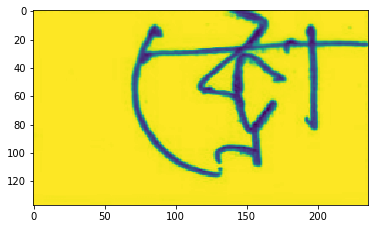

In [0]:
angle=0
image_center = tuple(np.array(img.shape[1::-1]) / 2)
matrix = cv2.getRotationMatrix2D(image_center, angle, 1.0)
image = cv2.warpAffine(img, matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
matrix = cv2.getRotationMatrix2D(image_center, 0, 1.0)
image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
plt.imshow(image)

## threshold

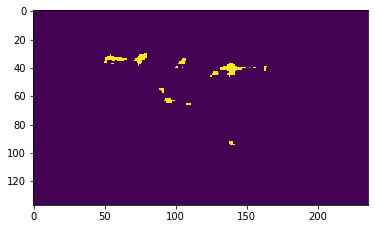

In [0]:
_, b = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY_INV)
plt.imshow(b)

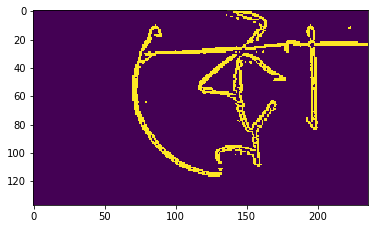

In [0]:
b = cv2.adaptiveThreshold(image, 65,cv2.THRESH_BINARY_INV,cv2.THRESH_BINARY_INV, 3, 5)
plt.imshow(b)

In [0]:
cv2.ADAPTIVE_THRESH_GAUSSIAN_C

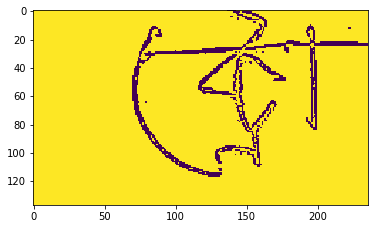

In [0]:
b = cv2.adaptiveThreshold(image, 65,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 6)
plt.imshow(b)

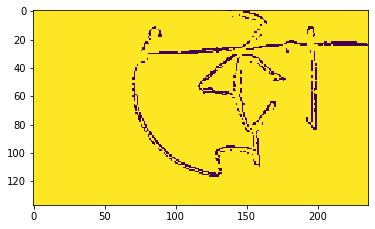

In [0]:
b = cv2.adaptiveThreshold(image, 65,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 15)
plt.imshow(b)

## contur

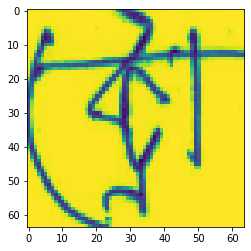

In [0]:
_, thresh = cv2.threshold(image, 85, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

idx = 0 
ls_xmin = []
ls_ymin = []
ls_xmax = []
ls_ymax = []
for cnt in contours:
    idx += 1
    x,y,w,h = cv2.boundingRect(cnt)
    ls_xmin.append(x)
    ls_ymin.append(y)
    ls_xmax.append(x + w)
    ls_ymax.append(y + h)
xmin = min(ls_xmin)
ymin = min(ls_ymin)
xmax = max(ls_xmax)
ymax = max(ls_ymax)

roi = image[ymin:ymax,xmin:xmax]
resized_roi = cv2.resize(roi, (64, 64),interpolation=cv2.INTER_AREA)
plt.imshow(resized_roi)

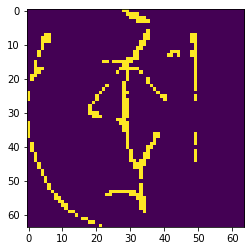

In [0]:
img = resized_roi
_, b = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV)
plt.imshow(b)

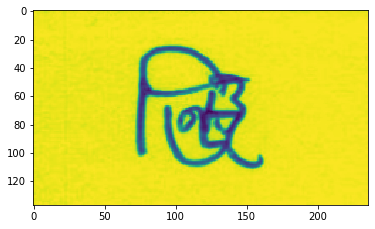

In [0]:
img = data.iloc[6].values.reshape(137, 236)
plt.imshow(img)

In [0]:
train = pd.read_csv(PATH + 'train.csv')
train.head(7)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
5,Train_5,153,9,0,স্পো
6,Train_6,52,2,0,ঞ্জি


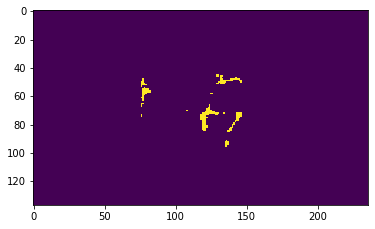

In [0]:
_, b = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY_INV)
plt.imshow(b)

In [0]:
contours, _ = cv2.findContours(b,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

In [0]:
for cnt in contours:
    idx += 1    
    x,y,w,h = cv2.boundingRect(cnt)

In [0]:
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a green rectangle to visualize the bounding rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

In [0]:
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a green rectangle to visualize the bounding rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # get the min area rect
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    box = np.int0(box)
    # draw a red 'nghien' rectangle
    cv2.drawContours(img, [box], 0, (0, 0, 255))

    # finally, get the min enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(c)
    # convert all values to int
    center = (int(x), int(y))
    radius = int(radius)
    # and draw the circle in blue
    img = cv2.circle(img, center, radius, (255, 0, 0), 2)

print(len(contours))
cv2.drawContours(img, contours, -1, (255, 255, 0), 1)